In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# ==============================================================
# 1️⃣ Load the dataset
# ==============================================================
df = pd.read_csv("students_adaptability_level_online_education.csv")

print("=== Dataset Overview ===")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print()


=== Dataset Overview ===
Rows: 1205, Columns: 14



### Basic Preprocessing

In [3]:


# ==============================================================
# 2️⃣ Check for missing values
# ==============================================================
print("=== Missing Values Check ===")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "✅ No missing values found.")
print()

# ==============================================================
# 3️⃣ Check for duplicates (do NOT remove them)
# ==============================================================
duplicates_count = df.duplicated().sum()
print(f"=== Duplicate Rows Check ===\nTotal Duplicates Found: {duplicates_count}")
if duplicates_count > 0:
    print("⚠️ Duplicates exist but will NOT be removed (kept for representation).")
print()

# ==============================================================
# 4️⃣ Outlier Detection (for numeric columns only)
# ==============================================================
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if numeric_cols:
    print("=== Outlier Detection (IQR method) ===")
    for col in numeric_cols:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        print(f"{col}: {len(outliers)} outliers")
else:
    print("✅ No numeric columns available for outlier detection.")
print()




=== Missing Values Check ===
✅ No missing values found.

=== Duplicate Rows Check ===
Total Duplicates Found: 949
⚠️ Duplicates exist but will NOT be removed (kept for representation).

✅ No numeric columns available for outlier detection.



##### Train Test Split

In [4]:
train_data, test_data = train_test_split( df, test_size=0.2, random_state=42)

print("\n✅ Data split into training and test sets.")
print(f"Training set: {train_data.shape[0]} rows")




✅ Data split into training and test sets.
Training set: 964 rows


In [5]:
train_data.dtypes

Gender                 object
Age                    object
Education Level        object
Institution Type       object
IT Student             object
Location               object
Load-shedding          object
Financial Condition    object
Internet Type          object
Network Type           object
Class Duration         object
Self Lms               object
Device                 object
Adaptivity Level       object
dtype: object

In [6]:
train_data.isna().sum()
 

Gender                 0
Age                    0
Education Level        0
Institution Type       0
IT Student             0
Location               0
Load-shedding          0
Financial Condition    0
Internet Type          0
Network Type           0
Class Duration         0
Self Lms               0
Device                 0
Adaptivity Level       0
dtype: int64

### MCA 

In [9]:
#!pip install prince

In [10]:

import prince

# --- Step 1: Prepare categorical data ---
data = train_data.copy()  # your full categorical dataframe

# --- Step 2: Apply MCA ---
mca = prince.MCA(n_components=10, random_state=42)
mca_result = mca.fit_transform(data)

mca.eigenvalues_summary


,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.248,14.49%,14.49%
1,0.189,11.02%,25.50%
2,0.148,8.62%,34.12%
3,0.125,7.28%,41.40%
4,0.100,5.86%,47.26%
5,0.094,5.50%,52.75%
6,0.088,5.11%,57.86%
7,0.074,4.29%,62.15%
8,0.072,4.19%,66.34%


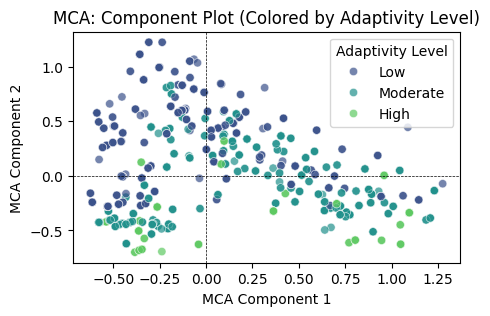

In [11]:

# --- Step 3: Combine MCA components with the original column for coloring ---
plot_df = mca_result.copy()
plot_df['Adaptivity Level'] = train_data['Adaptivity Level'].values  # original categorical column

# --- Step 4: Scatter plot of first two MCA components ---
plt.figure(figsize=(5, 3))
sns.scatterplot(
    x=plot_df.iloc[:, 0],
    y=plot_df.iloc[:, 1],
    hue=plot_df['Adaptivity Level'],
    palette='viridis',
    alpha=0.7
)
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('MCA Component 1')
plt.ylabel('MCA Component 2')
plt.title('MCA: Component Plot (Colored by Adaptivity Level)')
plt.legend(title='Adaptivity Level')
plt.show()


##  KModes

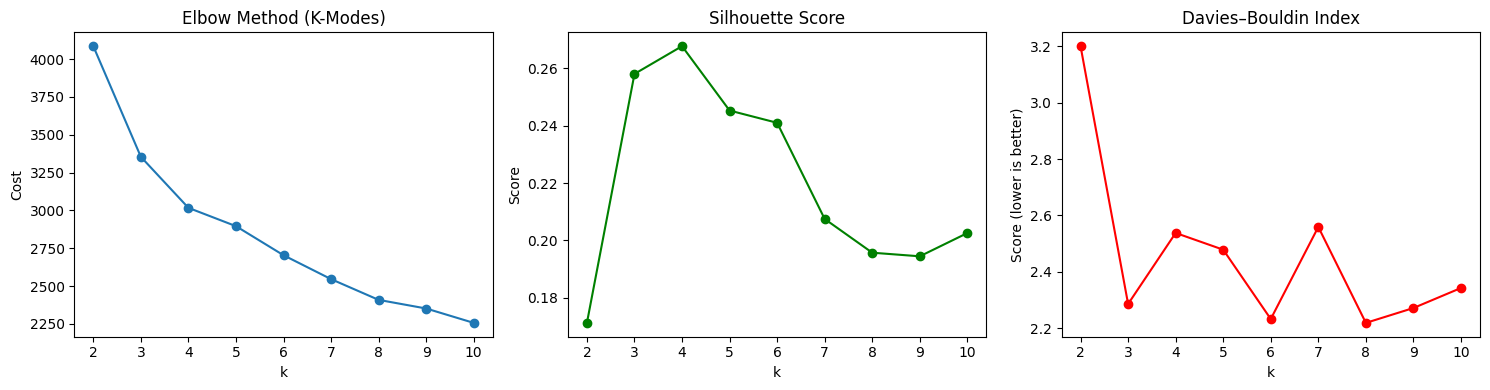

In [12]:

from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import LabelEncoder

# --- Step 1: Prepare categorical data ---
data = train_data.copy()  # your full categorical dataset

# --- Step 2: Encode data for distance metrics ---
# K-Modes works on string categories, but Silhouette needs numeric
le_data = data.apply(LabelEncoder().fit_transform)

# --- Step 3: K-Modes evaluation ---
costs = []
silhouettes = []
db_scores = []
K = range(2, 11)

for k in K:
    km = KModes(n_clusters=k, init='Cao', n_init=5, verbose=0, random_state=42)
    clusters = km.fit_predict(data) 
    costs.append(km.cost_)
    
    # Silhouette score (using encoded numeric version)
    silhouettes.append(silhouette_score(le_data, clusters, metric='hamming'))
    
    # Davies-Bouldin score (using encoded numeric version)
    db_scores.append(davies_bouldin_score(le_data, clusters))

# --- Step 4: Plot the 3 evaluation metrics ---
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(K, costs, 'o-')
plt.title('Elbow Method (K-Modes)')
plt.xlabel('k')
plt.ylabel('Cost')

plt.subplot(1, 3, 2)
plt.plot(K, silhouettes, 'o-', color='green')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Score')

plt.subplot(1, 3, 3)
plt.plot(K, db_scores, 'o-', color='red')
plt.title('Davies–Bouldin Index')
plt.xlabel('k')
plt.ylabel('Score (lower is better)')

plt.tight_layout()
plt.show()


## Encode catergorical varibles

In [13]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [14]:
# ==============================================================
# 5️⃣ Hybrid Encoding: Ordinal + Label Encoding
# ==============================================================

df_encoded = df.copy()

# --- Define ordinal features with meaningful order ---
ordinal_mappings = {
    'Age': ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30'],
    'Education Level': ['School', 'College', 'University'],
    'Load-shedding': ['Low', 'High'],
    'Financial Condition': ['Poor', 'Mid', 'Rich'],
    'Network Type': ['2G', '3G', '4G'],
    'Class Duration': ['0', '1-3', '3-6'],
    'Adaptivity Level': ['Low', 'Moderate', 'High']  # Target variable
}

ordinal_features = list(ordinal_mappings.keys())
nominal_features = [col for col in df.columns if col not in ordinal_features]

# --- Apply Ordinal Encoding ---
ordinal_encoder = OrdinalEncoder(categories=[ordinal_mappings[col] for col in ordinal_features])
df_encoded[ordinal_features] = ordinal_encoder.fit_transform(df_encoded[ordinal_features])

# --- Apply Label Encoding for Nominal Features ---
label_encoders = {}
encoding_mappings = {}

for col in nominal_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    encoding_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# --- Record Ordinal mappings ---
for col in ordinal_mappings:
    encoding_mappings[col] = {cat: i for i, cat in enumerate(ordinal_mappings[col])}

print("✅ Hybrid Encoding Complete (Ordinal + Label Encoding).\n")

# Show encoding interpretation
print("=== Encoding Mappings for Each Feature ===")
for col, mapping in encoding_mappings.items():
    print(f"\n{col}:")
    for k, v in mapping.items():
        print(f"  {k} → {v}")


✅ Hybrid Encoding Complete (Ordinal + Label Encoding).

=== Encoding Mappings for Each Feature ===

Gender:
  Boy → 0
  Girl → 1

Institution Type:
  Government → 0
  Non Government → 1

IT Student:
  No → 0
  Yes → 1

Location:
  No → 0
  Yes → 1

Internet Type:
  Mobile Data → 0
  Wifi → 1

Self Lms:
  No → 0
  Yes → 1

Device:
  Computer → 0
  Mobile → 1
  Tab → 2

Age:
  1-5 → 0
  6-10 → 1
  11-15 → 2
  16-20 → 3
  21-25 → 4
  26-30 → 5

Education Level:
  School → 0
  College → 1
  University → 2

Load-shedding:
  Low → 0
  High → 1

Financial Condition:
  Poor → 0
  Mid → 1
  Rich → 2

Network Type:
  2G → 0
  3G → 1
  4G → 2

Class Duration:
  0 → 0
  1-3 → 1
  3-6 → 2

Adaptivity Level:
  Low → 0
  Moderate → 1
  High → 2


In [15]:
train_data_encoded, test_data_encoded = train_test_split( df_encoded, test_size=0.2, random_state=42)

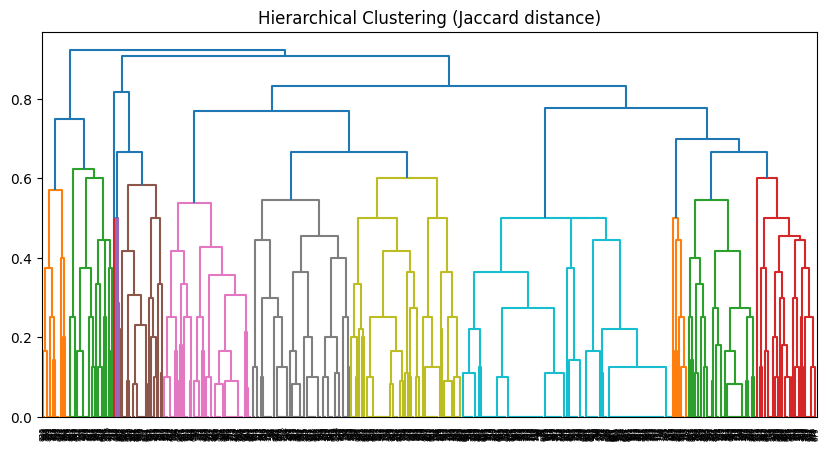

In [16]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Compute Jaccard distance
dist_matrix = pdist(train_data_encoded, metric='jaccard')
dist_square = squareform(dist_matrix)
Z = linkage(dist_matrix, method='complete')

plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title("Hierarchical Clustering (Jaccard distance)")
plt.show()


In [17]:
from scipy.cluster.hierarchy import linkage, fcluster
k = 5
cluster_labels = fcluster(Z, k, criterion='maxclust')


In [18]:
from sklearn.metrics import silhouette_score

if len(np.unique(cluster_labels)) > 1:
    score = silhouette_score(dist_square, cluster_labels, metric='precomputed')
    print(f"Silhouette Score: {score:.4f}")
else:
    print("Cannot compute Silhouette Score: only one cluster assigned.")


Silhouette Score: 0.1521


In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np


# --- Step 2: Apply DBSCAN ---
# eps: max distance between two points to be considered neighbors
# min_samples: min points to form a dense region
dbscan = DBSCAN(eps=0.5, min_samples=3, metric='hamming')
clusters = dbscan.fit_predict(train_data_encoded)

# --- Step 3: Analyze results ---
print("Number of clusters (excluding noise):", len(set(clusters)) - (1 if -1 in clusters else 0))
print("Number of noise points:", np.sum(clusters == -1))

# --- Step 4: Silhouette score (ignore noise points) ---
mask = clusters != -1
if len(np.unique(clusters[mask])) > 1:  # need at least 2 clusters
    sil_score = silhouette_score(X_encoded[mask], clusters[mask], metric='hamming')
    print("Silhouette Score:", sil_score)
else:
    print("Silhouette Score: Not applicable (less than 2 clusters)")


Number of clusters (excluding noise): 1
Number of noise points: 0
Silhouette Score: Not applicable (less than 2 clusters)


In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 964 entries, 294 to 1126
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               964 non-null    object
 1   Age                  964 non-null    object
 2   Education Level      964 non-null    object
 3   Institution Type     964 non-null    object
 4   IT Student           964 non-null    object
 5   Location             964 non-null    object
 6   Load-shedding        964 non-null    object
 7   Financial Condition  964 non-null    object
 8   Internet Type        964 non-null    object
 9   Network Type         964 non-null    object
 10  Class Duration       964 non-null    object
 11  Self Lms             964 non-null    object
 12  Device               964 non-null    object
 13  Adaptivity Level     964 non-null    object
dtypes: object(14)
memory usage: 113.0+ KB


In [21]:
train_data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 964 entries, 294 to 1126
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               964 non-null    int32  
 1   Age                  964 non-null    float64
 2   Education Level      964 non-null    float64
 3   Institution Type     964 non-null    int32  
 4   IT Student           964 non-null    int32  
 5   Location             964 non-null    int32  
 6   Load-shedding        964 non-null    float64
 7   Financial Condition  964 non-null    float64
 8   Internet Type        964 non-null    int32  
 9   Network Type         964 non-null    float64
 10  Class Duration       964 non-null    float64
 11  Self Lms             964 non-null    int32  
 12  Device               964 non-null    int32  
 13  Adaptivity Level     964 non-null    float64
dtypes: float64(7), int32(7)
memory usage: 86.6 KB


In [22]:
#!pip install pyLCA

In [23]:
from sklearn.mixture import GaussianMixture
# Step 2: Fit Gaussian Mixture Model
n_classes = 3  # choose number of latent classes
gmm = GaussianMixture(n_components=n_classes, random_state=42)
gmm.fit(train_data_encoded)

# Step 3: Predict latent classes
cluster_labels = gmm.predict(train_data_encoded)
train_data['LCA_Cluster'] = cluster_labels

# Step 4: Inspect cluster counts
print(train_data['LCA_Cluster'].value_counts())

LCA_Cluster
0    364
2    306
1    294
Name: count, dtype: int64


In [24]:
score = silhouette_score(train_data_encoded, cluster_labels, metric='euclidean')
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.1804


## Spectral Clustering with gower distance(before encoding)

In [27]:
#!pip install gower

Computing Gower distance matrix...
Silhouette Score: 0.2927


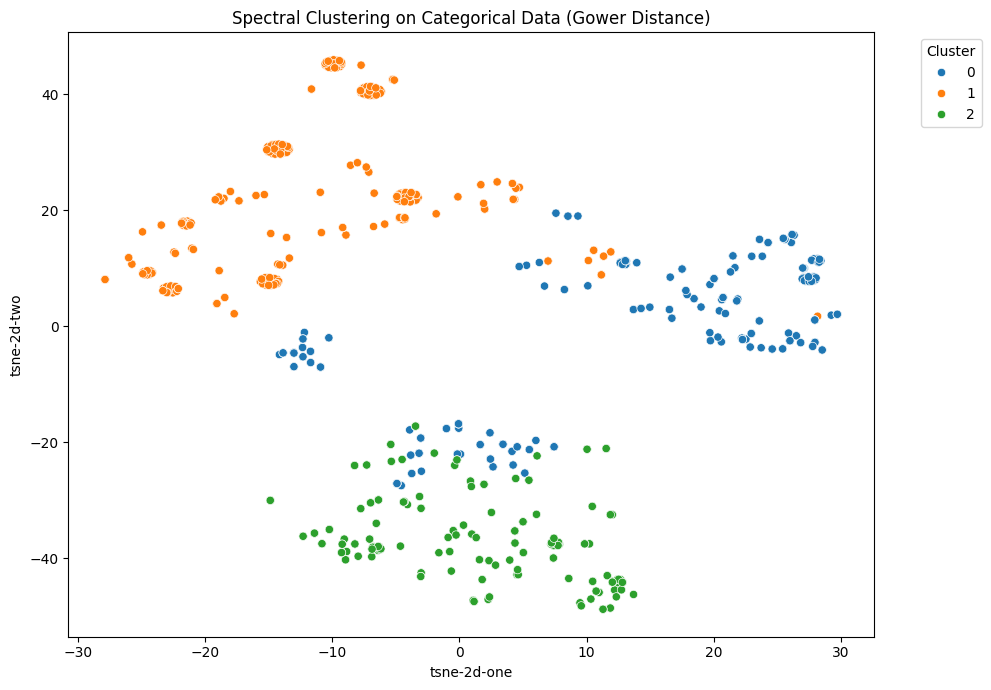

Cluster counts in training data:
Spectral_Cluster
1    358
0    320
2    286
Name: count, dtype: int64


In [28]:
# --- Step 0: Imports ---
import pandas as pd
import gower
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Compute Gower distance ---

print("Computing Gower distance matrix...")
gower_dist = gower.gower_matrix(train_data)  
# --- Step 2: Convert distance to similarity ---
affinity_matrix = 1 - gower_dist  # similarity = 1 - distance

# --- Step 3: Spectral Clustering ---
n_clusters = 3  # choose number of clusters
spectral = SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed',  # use similarity matrix
    random_state=42
)
cluster_labels = spectral.fit_predict(affinity_matrix)
train_data['Spectral_Cluster'] = cluster_labels

# --- Step 4: Silhouette score ---
sil_score = silhouette_score(gower_dist, cluster_labels, metric='precomputed')
print(f"Silhouette Score: {sil_score:.4f}")

# --- Step 5: t-SNE for visualization ---
tsne = TSNE(metric='precomputed', n_components=2, random_state=42, init='random')
tsne_results = tsne.fit_transform(gower_dist)
train_data['tsne-2d-one'] = tsne_results[:, 0]
train_data['tsne-2d-two'] = tsne_results[:, 1]

# --- Step 6: Plot clusters ---
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue='Spectral_Cluster',
    palette='tab10',
    data=train_data,
    legend='full'
)
plt.title("Spectral Clustering on Categorical Data (Gower Distance)")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Step 7: Cluster counts ---
print("Cluster counts in training data:")
print(train_data['Spectral_Cluster'].value_counts())


## Agglomerative Nesting for Categorical Data (AGNES)
###### After encoding

In [29]:

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster


# --- Step 2: Compute pairwise Hamming distance matrix
dist_matrix = pdist(train_data_encoded.values, metric='hamming')
dist_square = squareform(dist_matrix)

# --- Step 3: Agglomerative clustering using linkage
# Use 'average', 'complete', or 'single' linkage
Z = linkage(dist_matrix, method='average')  # distance vector input

# --- Step 4: Cut the dendrogram to form clusters (e.g., 3 clusters)
n_clusters = 3
cluster_labels = fcluster(Z, t=n_clusters, criterion='maxclust')

# --- Step 5: Silhouette score (precomputed distance)
score = silhouette_score(dist_square, cluster_labels, metric='precomputed')
print(f"Silhouette Score: {score:.4f}")



Silhouette Score: 0.2545


## ROCK (RObust Clustering using linKs)

In [30]:
from itertools import combinations

# --- Step 2: Define similarity (e.g., simple matching / Hamming)
def similarity(row1, row2):
    return np.sum(row1 == row2) / len(row1)

# --- Step 3: Build similarity matrix
n = len(train_data_encoded)
sim_matrix = np.zeros((n, n))
for i, j in combinations(range(n), 2):
    sim = similarity(train_data_encoded.iloc[i].values, train_data_encoded.iloc[j].values)
    sim_matrix[i, j] = sim
    sim_matrix[j, i] = sim

# --- Step 4: Set a threshold to define links
threshold = 0.7  # similarity threshold for links
links = (sim_matrix > threshold).astype(int)

# --- Step 5: ROCK clustering (simplified)
# Initialize each point as its own cluster
clusters = [{i} for i in range(n)]

def merge_clusters(clusters, links, threshold_links=1):
    merged = True
    while merged:
        merged = False
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                # Count links between clusters
                link_count = sum(links[a, b] for a in clusters[i] for b in clusters[j])
                if link_count >= threshold_links:
                    clusters[i] = clusters[i].union(clusters[j])
                    clusters.pop(j)
                    merged = True
                    break
            if merged:
                break
    return clusters

# Merge clusters based on links
final_clusters = merge_clusters(clusters, links, threshold_links=1)

# --- Step 6: Assign cluster labels
cluster_labels = np.zeros(n)
for idx, cluster in enumerate(final_clusters):
    for point in cluster:
        cluster_labels[point] = idx + 1

train_data_encoded['Cluster'] = cluster_labels
print(train_data_encoded.head())

     Gender  Age  Education Level  Institution Type  IT Student  Location  \
294       1  0.0              0.0                 0           0         1   
876       0  2.0              0.0                 1           0         1   
382       0  2.0              0.0                 1           0         1   
634       1  4.0              2.0                 0           0         1   
906       1  2.0              0.0                 0           0         1   

     Load-shedding  Financial Condition  Internet Type  Network Type  \
294            0.0                  2.0              0           2.0   
876            0.0                  1.0              0           1.0   
382            0.0                  1.0              0           1.0   
634            0.0                  1.0              1           1.0   
906            0.0                  1.0              1           1.0   

     Class Duration  Self Lms  Device  Adaptivity Level  Cluster  
294             1.0         1       1